In [35]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyproj import Proj
import dateutil

In [36]:
f = h5pyd.File("/nrel/wtk-us.h5")
# list the datasets in the file
for k in f:
    dset = f[k]
    print(f"{dset.name} {dset.shape}")

/DIF (61368, 1602, 2976)
/DNI (61368, 1602, 2976)
/GHI (61368, 1602, 2976)
/coordinates (1602, 2976)
/datetime (61368,)
/inversemoninobukhovlength_2m (61368, 1602, 2976)
/precipitationrate_0m (61368, 1602, 2976)
/pressure_0m (61368, 1602, 2976)
/pressure_100m (61368, 1602, 2976)
/pressure_200m (61368, 1602, 2976)
/relativehumidity_2m (61368, 1602, 2976)
/status (61368,)
/temperature_100m (61368, 1602, 2976)
/temperature_10m (61368, 1602, 2976)
/temperature_120m (61368, 1602, 2976)
/temperature_140m (61368, 1602, 2976)
/temperature_160m (61368, 1602, 2976)
/temperature_200m (61368, 1602, 2976)
/temperature_2m (61368, 1602, 2976)
/temperature_40m (61368, 1602, 2976)
/temperature_60m (61368, 1602, 2976)
/temperature_80m (61368, 1602, 2976)
/winddirection_100m (61368, 1602, 2976)
/winddirection_10m (61368, 1602, 2976)
/winddirection_120m (61368, 1602, 2976)
/winddirection_140m (61368, 1602, 2976)
/winddirection_160m (61368, 1602, 2976)
/winddirection_200m (61368, 1602, 2976)
/winddirection

In [37]:
# get reference to windspeed_10m dataset
dset = f['windspeed_10m']
dset.shape    

(61368, 1602, 2976)

In [38]:
dt = f["datetime"]
dt = pd.DataFrame({"datetime": dt[:]},index=range(0,dt.shape[0]))
dt['datetime'] = dt['datetime'].apply(dateutil.parser.parse)
dt.head()

,datetime
0,2007-01-01 00:00:00
1,2007-01-01 01:00:00
2,2007-01-01 02:00:00
3,2007-01-01 03:00:00
4,2007-01-01 04:00:00


In [39]:
twentyten = dt.loc[(dt.datetime >= '2010-01-01') & (dt.datetime < '2011-01-01')].index
twentyten

Index([26304, 26305, 26306, 26307, 26308, 26309, 26310, 26311, 26312, 26313,
       ...
       35054, 35055, 35056, 35057, 35058, 35059, 35060, 35061, 35062, 35063],
      dtype='int64', length=8760)

In [40]:
timestep = dt.loc[dt.datetime == '2012-04-01 12:00:00'].index[0]
timestep

np.int64(46020)

In [41]:
%time data = dset[timestep,::8,::8]   # extract every 8th record at a particular time

CPU times: total: 15.6 ms
Wall time: 4.03 s


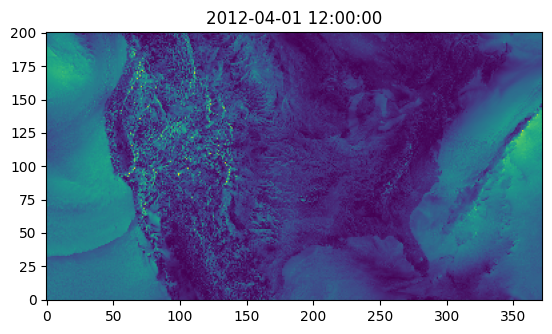

In [42]:
plt.title(str(dt.loc[timestep,"datetime"]))
plt.imshow(data, origin="lower")

# Specific Location

In [43]:
# This function finds the nearest x/y indices for a given lat/lon.
# Rather than fetching the entire coordinates database, which is 500+ MB, this
# uses the Proj4 library to find a nearby point and then converts to x/y indices
def indicesForCoord(f, lat_index, lon_index):
    dset_coords = f['coordinates']
    projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                    +lat_0=38.47240422490422 +lon_0=-96.0 
                    +x_0=0 +y_0=0 +ellps=sphere 
                    +units=m +no_defs """
    projectLcc = Proj(projstring)
    origin_ll = reversed(dset_coords[0][0])  # Grab origin directly from database
    origin = projectLcc(*origin_ll)
    
    coords = (lon_index,lat_index)
    coords = projectLcc(*coords)
    delta = np.subtract(coords, origin)
    ij = [int(round(x/2000)) for x in delta]
    return tuple(reversed(ij))

NewYorkCity = (40.7128, -74.0059)
NewYorkCity_idx = indicesForCoord( f, NewYorkCity[0], NewYorkCity[1] )

print("y,x indices for New York City: \t\t {}".format(NewYorkCity_idx))
print("Coordinates of New York City: \t {}".format(NewYorkCity))
print("Coordinates of nearest point: \t {}".format(f["coordinates"][NewYorkCity_idx[0]][NewYorkCity_idx[1]]))

y,x indices for New York City: 		 (1044, 2375)
Coordinates of New York City: 	 (40.7128, -74.0059)
Coordinates of nearest point: 	 (40.709702, -73.992798)


In [44]:
# Get the entire 2010 timeseries data for a point in NYC
%time tseries = dset[min(twentyten):max(twentyten)+1, NewYorkCity_idx[0], NewYorkCity_idx[1]]

CPU times: total: 0 ns
Wall time: 5.28 s


Text(0.5, 1.0, 'NYC Windspeed in 2010')

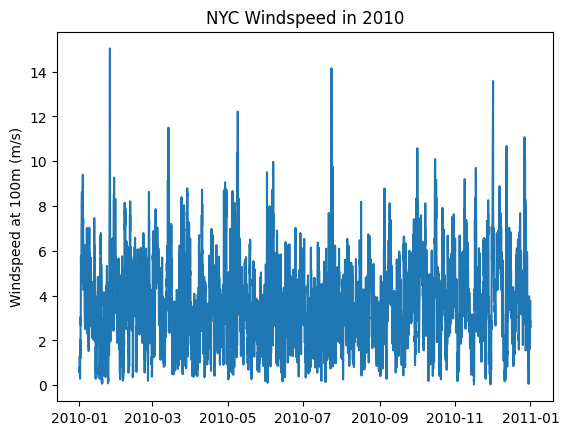

In [45]:
plt.plot(dt.iloc[twentyten,].datetime, tseries)
plt.ylabel("Windspeed at 100m (m/s)")
plt.title("NYC Windspeed in 2010")